<a href="https://colab.research.google.com/github/zychang2/COVID-19-Detection/blob/main/supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
# !pip install plotly

In [ ]:
import opendatasets as op
import plotly
import pathlib
import cv2
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import pandas as pd
from torchvision.transforms import v2
from torchvision import transforms

In [ ]:
!pip show torchvision

Name: torchvision
Version: 0.16.0+cu118
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, requests, torch
Required-by: fastai


In [ ]:
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

# username: cs7641lol
# key: 2f03f28c325ac1995a7d8072b82fa329

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: cs7641lol
Your Kaggle Key: ··········


100%|██████████| 778M/778M [00:36<00:00, 22.3MB/s]


In [ ]:
datasetFolder_covid = "covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
datasetFolder_lo = "covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
datasetFolder_normal = "covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
datasetFolder_vp = "covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

dataset_covid = pathlib.Path(datasetFolder_covid)
dataset_lo = pathlib.Path(datasetFolder_lo)
dataset_normal = pathlib.Path(datasetFolder_normal)
dataset_vp = pathlib.Path(datasetFolder_vp)


list_image_covid = list(dataset_covid.glob("*.*"))
list_image_lo = list(dataset_lo.glob("*.*"))
list_image_normal = list(dataset_normal.glob("*.*"))
list_image_vp = list(dataset_vp.glob("*.*"))


In [ ]:
datasetFolder_cmask = "covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks"
datasetFolder_nmask = "covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks"
datasetFolder_lomask = "covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks"
datasetFolder_vpmask = "covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks"

dataset_cm = pathlib.Path(datasetFolder_cmask)
dataset_nm = pathlib.Path(datasetFolder_nmask)
dataset_lm = pathlib.Path(datasetFolder_lomask)
dataset_vm = pathlib.Path(datasetFolder_vpmask)

list_image_nmask = list(dataset_nm.glob("*.*"))
list_image_cmask = list(dataset_cm.glob("*.*"))
list_image_lmask = list(dataset_lm.glob("*.*"))
list_image_vmask = list(dataset_vm.glob("*.*"))

# c: covid, n: normal, l: lung opacity, v: viral pneumonia

In [ ]:
print(cv2.imread(os.path.join(list_image_nmask[100])).shape)
print(cv2.imread(os.path.join(list_image_covid[100])).shape)

(256, 256, 3)
(299, 299, 3)


In [ ]:
# Using provided masks
# Comparison
train_m = []

for i in tqdm(range(1000)):
    _m = cv2.imread(os.path.join(list_image_nmask[i])) / 255.0
    _i = cv2.imread(os.path.join(list_image_normal[i]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    train_m.append(_m * _i)

for i in tqdm(range(1000)):
    _m = cv2.imread(os.path.join(list_image_cmask[i])) / 255.0
    _i = cv2.imread(os.path.join(list_image_covid[i]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    train_m.append(_m * _i)

for i in tqdm(range(1000)):
    _m = cv2.imread(os.path.join(list_image_lmask[i])) / 255.0
    _i = cv2.imread(os.path.join(list_image_lo[i]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    train_m.append(_m * _i)

for i in tqdm(range(1000)):
    _m = cv2.imread(os.path.join(list_image_vmask[i])) / 255.0
    _i = cv2.imread(os.path.join(list_image_vp[i]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    train_m.append(_m * _i)

100%|██████████| 1000/1000 [00:06<00:00, 143.48it/s]


In [ ]:
test_m = []

for i in tqdm(range(200)):
    _m = cv2.imread(os.path.join(list_image_nmask[i + 1000])) / 255.0
    _i = cv2.imread(os.path.join(list_image_normal[i + 1000]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    test_m.append(_m * _i)

for i in tqdm(range(200)):
    _m = cv2.imread(os.path.join(list_image_cmask[i + 1000])) / 255.0
    _i = cv2.imread(os.path.join(list_image_covid[i + 1000]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    test_m.append(_m * _i)

for i in tqdm(range(200)):
    _m = cv2.imread(os.path.join(list_image_lmask[i + 1000])) / 255.0
    _i = cv2.imread(os.path.join(list_image_lo[i + 1000]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    test_m.append(_m * _i)

for i in tqdm(range(200)):
    _m = cv2.imread(os.path.join(list_image_vmask[i + 1000])) / 255.0
    _i = cv2.imread(os.path.join(list_image_vp[i + 1000]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    test_m.append(_m * _i)

100%|██████████| 200/200 [00:01<00:00, 159.89it/s]


In [ ]:
train_labels = [0] * 1000 + [1] * 1000 + [2] * 1000 + [3] * 1000

In [ ]:
test_labels = [0] * 200 + [1] * 200 + [2] * 200 + [3] * 200

In [ ]:
# train_labels = np.zeros((4000, 4))
# train_labels[:1000, 0] = 1
# train_labels[1000:2000, 1] = 1
# train_labels[2000:3000, 2] = 1
# train_labels[3000:, 3] = 1

In [ ]:
# test_labels = np.zeros((800, 4))
# test_labels[:200, 0] = 1
# test_labels[200:400, 1] = 1
# test_labels[400:600, 2] = 1
# test_labels[600:, 3] = 1

In [ ]:
# Without masks
train_nm = []

for i in tqdm(range(1000)):
    # _m = cv2.imread(os.path.join(list_image_nmask[i])) / 255.0
    _i = cv2.imread(os.path.join(list_image_normal[i]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    train_nm.append(_i)

for i in tqdm(range(1000)):
    # _m = cv2.imread(os.path.join(list_image_cmask[i])) / 255.0
    _i = cv2.imread(os.path.join(list_image_covid[i]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    train_nm.append(_i)

for i in tqdm(range(1000)):
    # _m = cv2.imread(os.path.join(list_image_lmask[i])) / 255.0
    _i = cv2.imread(os.path.join(list_image_lo[i]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    train_nm.append(_i)

for i in tqdm(range(1000)):
    # _m = cv2.imread(os.path.join(list_image_vmask[i])) / 255.0
    _i = cv2.imread(os.path.join(list_image_vp[i]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    train_nm.append(_i)

100%|██████████| 1000/1000 [00:04<00:00, 246.46it/s]


In [ ]:
test_nm = []

for i in tqdm(range(200)):
    _i = cv2.imread(os.path.join(list_image_normal[i + 1000]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    test_nm.append(_i)

for i in tqdm(range(200)):
    _i = cv2.imread(os.path.join(list_image_covid[i + 1000]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    test_nm.append(_i)

for i in tqdm(range(200)):
    _i = cv2.imread(os.path.join(list_image_lo[i + 1000]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    test_nm.append(_i)

for i in tqdm(range(200)):
    _i = cv2.imread(os.path.join(list_image_vp[i + 1000]))
    _i = cv2.resize(_i, (256, 256), interpolation=cv2.INTER_AREA)
    test_nm.append(_i)

100%|██████████| 200/200 [00:00<00:00, 274.81it/s]


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx] / 255.0
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Rotation
def create_training_transformations():
    """
    First, convert the original PIL Images to Tensors,
    Second, add random horizontal flip with a probability of .2 (RandomApply is not needed)
    Finally, apply random rotation ranging from -36 degrees (clockwise) to 36 degrees (counter clockwise)
            with a probability of .2 (Look at RandomApply)
    RETURN: torchvision.transforms.v2.Compose object
    """
    transformation = [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.RandomHorizontalFlip(p=0.2),
        v2.RandomApply([v2.RandomRotation(degrees=(-36, 36))], p=0.2)
    ]
    return v2.Compose(transformation)

def create_testing_transformations():
    """
    First, convert the original PIL Images to Tensors,
    Second, add random horizontal flip with a probability of .2 (RandomApply is not needed)
    Finally, apply random rotation ranging from -36 degrees (clockwise) to 36 degrees (counter clockwise)
            with a probability of .2 (Look at RandomApply)
    RETURN: torchvision.transforms.v2.Compose object
    """
    transformation = [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ]
    return v2.Compose(transformation)

In [ ]:
# transform = None

train_dataset = MyDataset(train_nm, train_labels, create_training_transformations())
test_dataset = MyDataset(test_nm, test_labels, create_testing_transformations())
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
# trainDataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# testDataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

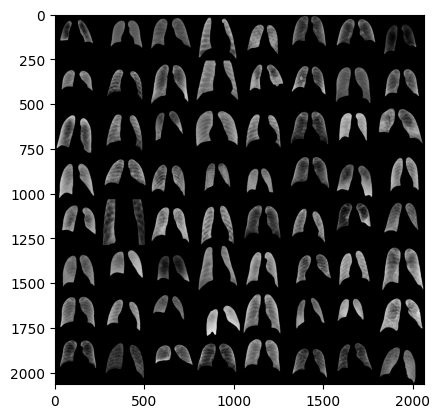

In [ ]:
# Test image
from google.colab.patches import cv2_imshow
import torchvision
cnt = 0
for image, label in testDataloader:
    # print(torch.max(image[0]))
    out = torchvision.utils.make_grid(image)
    plt.imshow(out.permute(1, 2, 0))
    # print(label)
    break


In [ ]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 128 x 128
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 x 64 x 64
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2), # 64 x 32 x 32
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2), # 64 x 16 x 16
            nn.Dropout(0.3)
        )

        # self.avg_pooling = nn.AdaptiveAvgPool2d((7, 7))

        # Linear layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 64, 512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        # x = self.avg_pooling(x)
        x = self.classifier(x)

        return x

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

for params in model.parameters():
    params.requires_grad = False
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 90.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model.fc.requires_grad = True

In [ ]:
from torch.optim import Adamax
from torch.optim.lr_scheduler import ExponentialLR
class Trainer():
    def __init__(self, model, trainset, testset, num_epochs=5, batch_size=16, init_lr=1e-3, device="cpu"):
        self.model = model.to(device)
        self.trainset = trainset
        self.testset = testset
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.init_lr = init_lr
        self.device = device

        self.train_loss_per_epoch = []
        self.train_accuracy_per_epoch = []
        self.test_loss_per_epoch = []
        self.test_accuracy_per_epoch = []

    def train(self):
        trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                            shuffle=True, num_workers=2)
        testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                            shuffle=False, num_workers=2)

        loss_fn = nn.CrossEntropyLoss()
        optimizer = Adamax(self.model.parameters(), lr=self.init_lr)
        scheduler = ExponentialLR(optimizer, gamma=0.9)

        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0
            correct = 0
            total = 0
            with tqdm(trainloader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}/{self.num_epochs}")
                for idx, data in enumerate(tepoch):
                    inputs, labels = data
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    total += len(labels)
                    correct += (outputs.argmax(dim=1) == labels).sum().item()
                    running_loss += loss.item()
                    tepoch.set_postfix(loss=running_loss / (idx + 1), accuracy=correct / total)
            scheduler.step()
            self.train_loss_per_epoch.append(running_loss / len(trainloader))
            self.train_accuracy_per_epoch.append(correct / total)
            print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
            print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
            print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
            # validation
            self.model.eval()
            with torch.no_grad():
                test_loss = 0
                test_correct = 0
                test_total = 0
                for idx, data in enumerate(testloader):
                    inputs, labels = data
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = loss_fn(outputs, labels)
                    test_loss += loss.item()
                    test_total += len(labels)
                    test_correct += (outputs.argmax(dim=1) == labels).sum().item()
                print(f"Epoch {epoch + 1}: Validation Loss: {test_loss / len(testloader):.2f}, Validation Accuracy: {test_correct / test_total:.3f}")
                self.test_loss_per_epoch.append(test_loss / len(testloader))
                self.test_accuracy_per_epoch.append(test_correct / test_total)


    def get_training_history(self):
        return (self.train_loss_per_epoch,
                self.train_accuracy_per_epoch,
                self.test_loss_per_epoch,
                self.test_accuracy_per_epoch
                )

    def predict(self, testloader):
        self.model.eval()
        predict_probs = []
        predictions = []
        ground_truth = []

        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                predict_probs.append(F.softmax(outputs, dim=1))
                predictions.append(outputs.argmax(dim=1))
                ground_truth.append(labels)

        return torch.cat(predict_probs).cpu(), torch.cat(predictions).cpu(), torch.cat(ground_truth).cpu()

In [ ]:
net = CNN()

In [ ]:
net = model

In [ ]:

num_epochs = 20
batch_size = 16
lr = 5e-3

device = ("cuda" if torch.cuda.is_available()
          else "cpu")
print(f"Using {device} device")

trainer = Trainer(net, train_dataset, test_dataset, num_epochs=num_epochs, batch_size=batch_size, init_lr=lr, device=device)
trainer.train()

Using cuda device


Epoch 1/20: 100%|██████████| 250/250 [00:15<00:00, 16.32batch/s, accuracy=0.681, loss=0.79]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 1: Validation Loss: 0.51, Validation Accuracy: 0.812


Epoch 2/20: 100%|██████████| 250/250 [00:15<00:00, 16.64batch/s, accuracy=0.759, loss=0.607]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 2: Validation Loss: 0.42, Validation Accuracy: 0.858


Epoch 3/20: 100%|██████████| 250/250 [00:14<00:00, 16.72batch/s, accuracy=0.791, loss=0.552]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 3: Validation Loss: 0.44, Validation Accuracy: 0.833


Epoch 4/20: 100%|██████████| 250/250 [00:15<00:00, 16.55batch/s, accuracy=0.79, loss=0.53]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 4: Validation Loss: 0.39, Validation Accuracy: 0.866


Epoch 5/20: 100%|██████████| 250/250 [00:15<00:00, 16.37batch/s, accuracy=0.799, loss=0.518]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 5: Validation Loss: 0.37, Validation Accuracy: 0.870


Epoch 6/20: 100%|██████████| 250/250 [00:15<00:00, 16.47batch/s, accuracy=0.797, loss=0.514]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 6: Validation Loss: 0.41, Validation Accuracy: 0.855


Epoch 7/20: 100%|██████████| 250/250 [00:15<00:00, 16.43batch/s, accuracy=0.819, loss=0.476]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 7: Validation Loss: 0.37, Validation Accuracy: 0.863


Epoch 8/20: 100%|██████████| 250/250 [00:15<00:00, 16.56batch/s, accuracy=0.817, loss=0.469]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 8: Validation Loss: 0.37, Validation Accuracy: 0.873


Epoch 9/20: 100%|██████████| 250/250 [00:15<00:00, 16.64batch/s, accuracy=0.832, loss=0.457]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 9: Validation Loss: 0.36, Validation Accuracy: 0.877


Epoch 10/20: 100%|██████████| 250/250 [00:14<00:00, 16.70batch/s, accuracy=0.822, loss=0.47]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 10: Validation Loss: 0.36, Validation Accuracy: 0.875


Epoch 11/20: 100%|██████████| 250/250 [00:15<00:00, 16.55batch/s, accuracy=0.82, loss=0.454]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 11: Validation Loss: 0.37, Validation Accuracy: 0.863


Epoch 12/20: 100%|██████████| 250/250 [00:15<00:00, 16.07batch/s, accuracy=0.827, loss=0.459]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 12: Validation Loss: 0.35, Validation Accuracy: 0.876


Epoch 13/20: 100%|██████████| 250/250 [00:15<00:00, 16.58batch/s, accuracy=0.825, loss=0.443]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 13: Validation Loss: 0.36, Validation Accuracy: 0.865


Epoch 14/20: 100%|██████████| 250/250 [00:14<00:00, 16.77batch/s, accuracy=0.827, loss=0.447]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 14: Validation Loss: 0.36, Validation Accuracy: 0.870


Epoch 15/20: 100%|██████████| 250/250 [00:15<00:00, 16.41batch/s, accuracy=0.829, loss=0.439]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 15: Validation Loss: 0.35, Validation Accuracy: 0.874


Epoch 16/20: 100%|██████████| 250/250 [00:15<00:00, 16.49batch/s, accuracy=0.822, loss=0.452]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 16: Validation Loss: 0.36, Validation Accuracy: 0.874


Epoch 17/20: 100%|██████████| 250/250 [00:15<00:00, 16.01batch/s, accuracy=0.839, loss=0.43]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 17: Validation Loss: 0.36, Validation Accuracy: 0.874


Epoch 18/20: 100%|██████████| 250/250 [00:15<00:00, 16.24batch/s, accuracy=0.836, loss=0.431]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 18: Validation Loss: 0.36, Validation Accuracy: 0.873


Epoch 19/20: 100%|██████████| 250/250 [00:15<00:00, 16.19batch/s, accuracy=0.826, loss=0.438]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 19: Validation Loss: 0.35, Validation Accuracy: 0.873


Epoch 20/20: 100%|██████████| 250/250 [00:15<00:00, 16.04batch/s, accuracy=0.841, loss=0.429]

torch.cuda.memory_allocated: 0.720148GB
torch.cuda.memory_reserved: 2.185547GB
torch.cuda.max_memory_reserved: 2.185547GB


Epoch 20: Validation Loss: 0.35, Validation Accuracy: 0.870


In [ ]:
print('Max testing accuracy: ', np.max(trainer.get_training_history()[3]))

Max testing accuracy:  0.8775


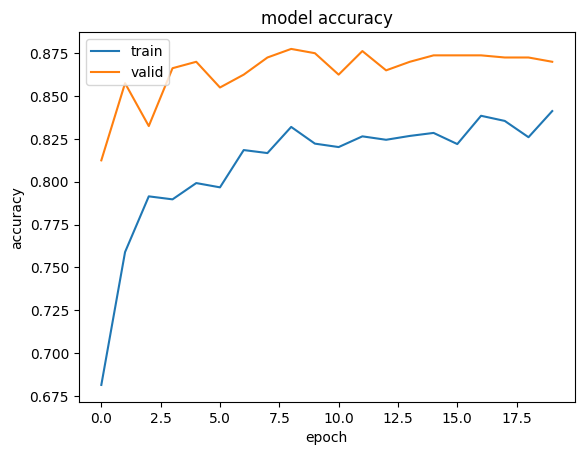

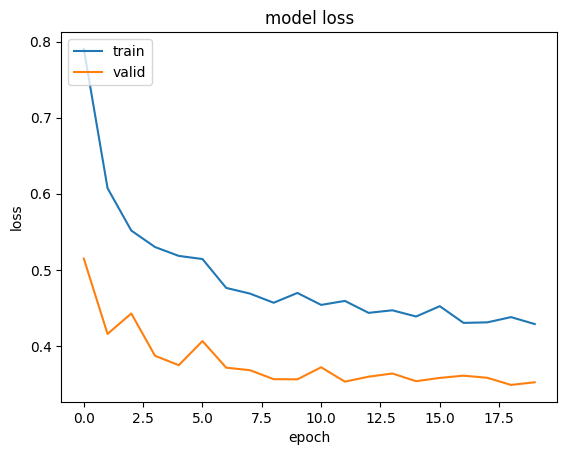

In [ ]:
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.get_training_history()

# summarize history for accuracy and loss
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()